In [17]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt
import seaborn as sns

In [18]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

In [19]:
train_df = pd.read_csv('data/processed/train_FD001_processed.csv')
test_df = pd.read_csv('data/processed/test_FD001_processed.csv')

In [20]:
np.random.seed(42)
all_engine_ids = train_df['engine'].unique()
np.random.shuffle(all_engine_ids)

In [21]:
split_percentage = 0.8
split_point = int(len(all_engine_ids) * split_percentage)
train_subset_ids = all_engine_ids[:split_point]
validation_ids = all_engine_ids[split_point:]

In [22]:
train_subset_df =train_df[train_df['engine'].isin(train_subset_ids)]
val_subset_df = train_df[train_df['engine'].isin(validation_ids)]

In [23]:
def create_sliding_windows(df, lookback=30):
    X, y = [], []
    for engine_id in df["engine"].unique():
        engine_data = df[df["engine"] == engine_id].reset_index(drop=True)
        for i in range(len(engine_data) - lookback + 1):
            window = engine_data.iloc[i:i + lookback]
            X.append(window.drop(columns=["engine", "cycle", "RUL"]).values.flatten())
            y.append(window["RUL"].iloc[-1])
    return np.array(X), np.array(y)

def get_last_window_per_engine(df, lookback=30):
    X_test, y_test = [], []
    for engine_id in df["engine"].unique():
        engine_data = df[df["engine"] == engine_id].reset_index(drop=True)
        if len(engine_data) >= lookback:
            window = engine_data.iloc[-lookback:]
            X_test.append(window.drop(columns=["engine", "cycle", "RUL"]).values.flatten())
            y_test.append(window["RUL"].iloc[-1])
    return np.array(X_test), np.array(y_test)

In [24]:
LOOKBACK = 30
X_train, y_train = create_sliding_windows(train_subset_df, lookback=LOOKBACK)
X_val, y_val = create_sliding_windows(val_subset_df, lookback=LOOKBACK)
X_test, y_test = get_last_window_per_engine(test_df, lookback=LOOKBACK)

print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}\n")

Data shapes:
X_train: (14020, 720), y_train: (14020,)
X_val:   (3711, 720), y_val:   (3711,)
X_test:  (100, 720), y_test:  (100,)



In [25]:
lgbm = lgb.LGBMRegressor(
    n_estimators=250,
    max_depth=15,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82834
[LightGBM] [Info] Number of data points in the train set: 14020, number of used features: 510
[LightGBM] [Info] Start training from score 92.992154


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,15
,learning_rate,0.05
,n_estimators,250
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### Validation Set Performance

In [26]:
y_pred_val = lgbm.predict(X_val)

/home/erikhs/code_files/rul-prediction/engg2112/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [27]:
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("--- Validation Set Performance ---")
print(f"Validation MAE: {mae_val:.2f}")
print(f"Validation RMSE: {rmse_val:.2f}\n")

print("--- Detailed Validation Predictions ---")
# true RUL is 0 since we are predicting the last cycle
for i, (true, pred) in enumerate(zip(y_val, y_pred_val)):
    print(f"Engine {i+1:03d} => True RUL = {true}, Predicted = {pred:.1f}")

--- Validation Set Performance ---
Validation MAE: 24.77
Validation RMSE: 35.21

--- Detailed Validation Predictions ---
Engine 001 => True RUL = 257.0, Predicted = 193.3
Engine 002 => True RUL = 256.0, Predicted = 187.4
Engine 003 => True RUL = 255.0, Predicted = 181.5
Engine 004 => True RUL = 254.0, Predicted = 182.6
Engine 005 => True RUL = 253.0, Predicted = 180.6
Engine 006 => True RUL = 252.0, Predicted = 196.7
Engine 007 => True RUL = 251.0, Predicted = 187.0
Engine 008 => True RUL = 250.0, Predicted = 175.4
Engine 009 => True RUL = 249.0, Predicted = 189.0
Engine 010 => True RUL = 248.0, Predicted = 181.9
Engine 011 => True RUL = 247.0, Predicted = 183.8
Engine 012 => True RUL = 246.0, Predicted = 175.0
Engine 013 => True RUL = 245.0, Predicted = 183.8
Engine 014 => True RUL = 244.0, Predicted = 171.1
Engine 015 => True RUL = 243.0, Predicted = 169.0
Engine 016 => True RUL = 242.0, Predicted = 171.9
Engine 017 => True RUL = 241.0, Predicted = 175.7
Engine 018 => True RUL = 240.

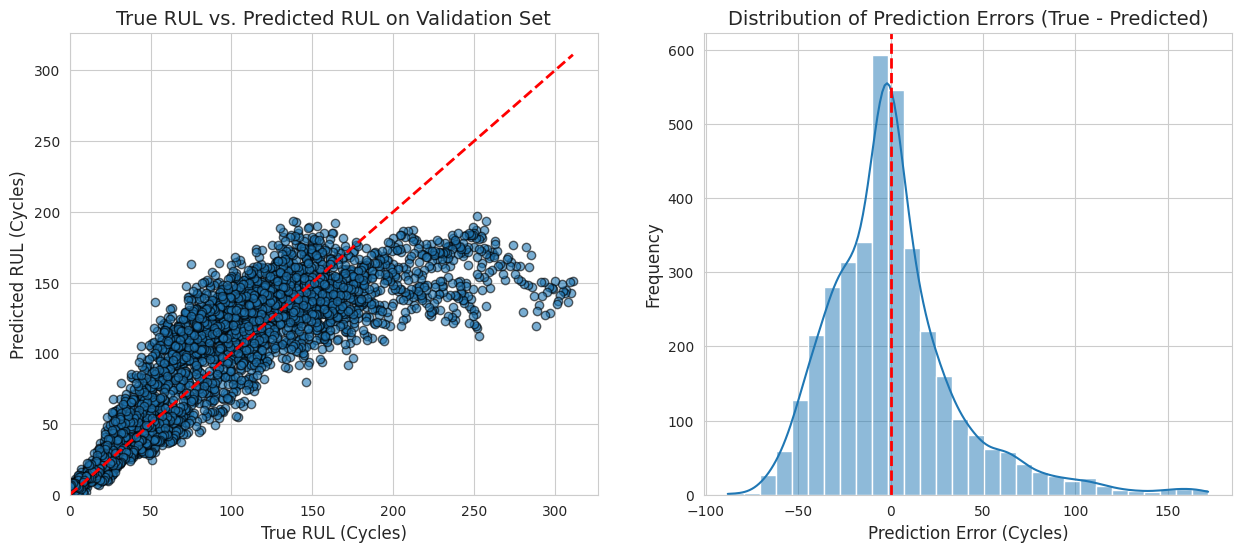

In [28]:
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred_val, alpha=0.6, edgecolors='k')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', lw=2)
plt.title('True RUL vs. Predicted RUL on Validation Set', fontsize=14)
plt.xlabel('True RUL (Cycles)', fontsize=12)
plt.ylabel('Predicted RUL (Cycles)', fontsize=12)
plt.xlim(0)
plt.ylim(0)
plt.grid(True)

errors = y_val - y_pred_val
plt.subplot(1, 2, 2)
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribution of Prediction Errors (True - Predicted)', fontsize=14)
plt.xlabel('Prediction Error (Cycles)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', lw=2)
plt.grid(True)

### Test Set Performance

In [29]:
y_pred_test = lgbm.predict(X_test)

/home/erikhs/code_files/rul-prediction/engg2112/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [30]:
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [31]:
print("--- Test Set Performance ---")
print(f"Test MAE: {mae_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}\n")

print("--- Detailed Test Predictions ---")
for i, (true, pred) in enumerate(zip(y_test, y_pred_test)):
    print(f"Engine {i+1:03d} => True RUL = {true}, Predicted = {pred:.1f}")

--- Test Set Performance ---
Test MAE: 16.94
Test RMSE: 23.27

--- Detailed Test Predictions ---
Engine 001 => True RUL = 112, Predicted = 151.4
Engine 002 => True RUL = 98, Predicted = 128.4
Engine 003 => True RUL = 69, Predicted = 69.5
Engine 004 => True RUL = 82, Predicted = 92.3
Engine 005 => True RUL = 91, Predicted = 120.9
Engine 006 => True RUL = 93, Predicted = 116.6
Engine 007 => True RUL = 91, Predicted = 101.9
Engine 008 => True RUL = 95, Predicted = 120.9
Engine 009 => True RUL = 111, Predicted = 141.0
Engine 010 => True RUL = 96, Predicted = 104.4
Engine 011 => True RUL = 97, Predicted = 90.5
Engine 012 => True RUL = 124, Predicted = 106.5
Engine 013 => True RUL = 95, Predicted = 83.4
Engine 014 => True RUL = 107, Predicted = 113.5
Engine 015 => True RUL = 83, Predicted = 145.6
Engine 016 => True RUL = 84, Predicted = 120.4
Engine 017 => True RUL = 50, Predicted = 48.6
Engine 018 => True RUL = 28, Predicted = 48.9
Engine 019 => True RUL = 87, Predicted = 123.4
Engine 020 =

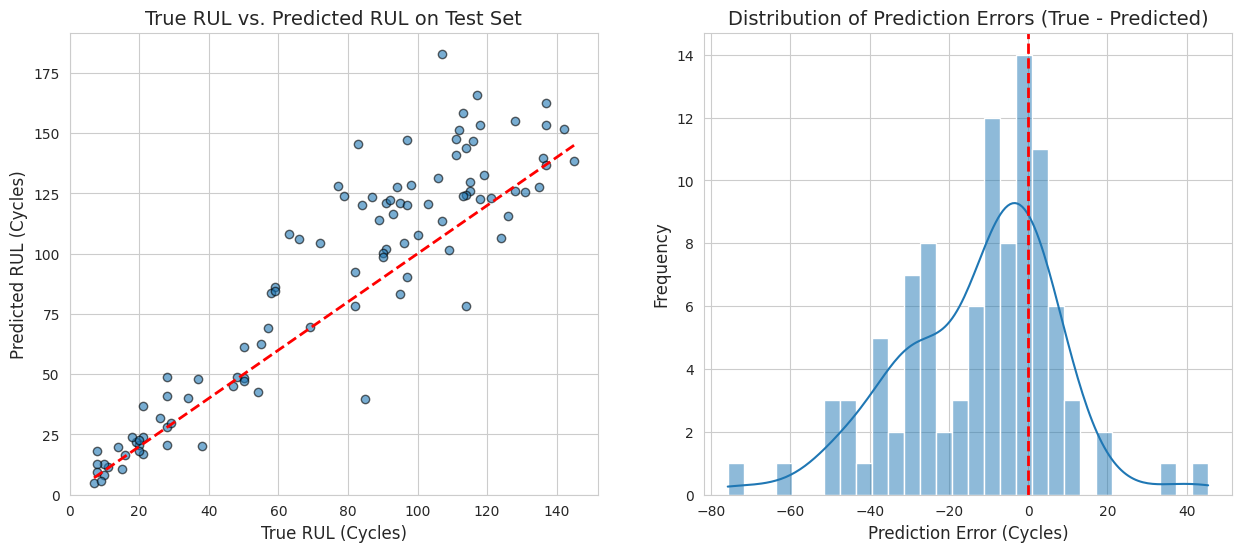

In [32]:
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.title('True RUL vs. Predicted RUL on Test Set', fontsize=14)
plt.xlabel('True RUL (Cycles)', fontsize=12)
plt.ylabel('Predicted RUL (Cycles)', fontsize=12)
plt.xlim(0)
plt.ylim(0)
plt.grid(True)

errors = y_test - y_pred_test
plt.subplot(1, 2, 2)
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribution of Prediction Errors (True - Predicted)', fontsize=14)
plt.xlabel('Prediction Error (Cycles)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', lw=2)
plt.grid(True)